In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(display="diagram")
pd.set_option('display.max_columns', None)

In [2]:
#reading data
df=pd.read_csv('accident_data.csv')

In [3]:
#checking missing values percentage
df.isnull().mean()*100

Accident_Index                                  0.000000
1st_Road_Class                                 29.143266
1st_Road_Number                                 0.000191
2nd_Road_Class                                 41.944925
2nd_Road_Number                                 1.030255
Accident_Severity                               0.000000
Carriageway_Hazards                             0.002766
Date                                            0.000000
Day_of_Week                                     0.000000
Did_Police_Officer_Attend_Scene_of_Accident     0.025654
Junction_Control                                0.000000
Junction_Detail                                 0.000000
Latitude                                        0.010586
Light_Conditions                                0.198746
Local_Authority_(District)                      0.000000
Local_Authority_(Highway)                       0.000000
Location_Easting_OSGR                           0.010586
Location_Northing_OSGR         

In [4]:
#identifying columns that contain upto 5 percent missing data
cols_upto_5=[var for var in df.columns if df[var].isnull().mean() < 0.05 and 
            df[var].isnull().mean() > 0]

In [5]:
new_df=df[cols_upto_5].dropna()

In [6]:
df2=df.merge(new_df)

In [7]:
#replacing with Data Missing
df2['2nd_Road_Class'] = df2['2nd_Road_Class'].str.replace('Unclassified','Data Missing')
df2['Junction_Control'] = df2['Junction_Control'].str.replace('Data missing or out of range','Data Missing')

In [8]:
#creating a function that checks the change in a column before and after impuatation
def compare(df,df2,col):
    temp=pd.concat([
    df[col].value_counts()/len(df),
    df2[col].value_counts()/len(df2)], axis=1)
    temp.columns=['before', 'after']
    return temp

In [9]:
#calling function to check change in LSOA_of_Accident_Location before and after imputation
compare(df,df2,'LSOA_of_Accident_Location')

,before,after
E01000004,1.652719e-03,1.509320e-03
E01011365,1.115800e-03,1.111661e-03
E01008440,7.877357e-04,8.022602e-04
E01004736,7.543571e-04,7.060683e-04
E01005131,6.980903e-04,6.723516e-04
...,...,...
E01004914,9.536752e-07,9.916690e-07
E01006651,9.536752e-07,9.916690e-07
E01006937,9.536752e-07,9.916690e-07
E01014980,9.536752e-07,9.916690e-07


In [10]:
#dropping this column based on above observation
df2 = df2.drop('LSOA_of_Accident_Location', axis=1)

In [11]:
#replacing misspelled values
df2['Junction_Control'] = df2['Junction_Control'].replace(to_replace='Auto traffic sigl', value='Auto traffic signal')

In [12]:
#splitting Time into Hours
df2['Hour']=df2['Time'].str.split(':').str[0]

#splitting Date into days and months
df2['Day']=df2['Date'].str.split('/').str[0]
df2['Month']=df2['Date'].str.split('/').str[1]

In [13]:
#converting Hour, Day, Month column type to integer
df2['Hour']=df2['Hour'].astype(int)
df2['Day']=df2['Day'].astype(int)
df2['Month']=df2['Month'].astype(int)

In [14]:
#drop the Time, Minute and Date columns
df2 = df2.drop('Time', axis=1)
df2 = df2.drop('Date', axis=1)

In [15]:
df2[['Hour', 'Day', 'Month','Year']]

,Hour,Day,Month,Year
0,17,5,1,2005
1,0,6,1,2005
2,21,10,1,2005
3,20,13,1,2005
4,22,15,1,2005
...,...,...,...,...
1008396,7,18,2,2010
1008397,3,21,2,2010
1008398,9,23,2,2010
1008399,18,23,2,2010


In [16]:
#drop columns that contain useless or extra information
df2 = df2.drop('Location_Easting_OSGR', axis=1)
df2 = df2.drop('Location_Northing_OSGR', axis=1)
df2 = df2.drop('Accident_Index', axis=1)

In [17]:
#create a copy of df2
df3=df2.copy()

In [18]:
#identify categorical and numeric features
cat_cols=df3.select_dtypes('object').columns
num_cols=df3.select_dtypes('number').columns

In [19]:
#drop accident_severity bcuz it will be one-hot encoded and the rest of the cat_cols will be label encoded
cat_cols=cat_cols.drop('Accident_Severity')

In [20]:
#identify columns containing more than 5 percent missing data
cols_morethan_5=[var for var in df3.columns if df3[var].isnull().mean() > 0.05 ]
cols_morethan_5

['1st_Road_Class', '2nd_Road_Class']

In [21]:
#create a column transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

ct = ColumnTransformer([
    ('Imputer', SimpleImputer(strategy='constant', fill_value='Data Missing'),cols_morethan_5),
    ('OrdinalEncoder', OrdinalEncoder(categories=[['Slight','Serious','Fatal']]),['Accident_Severity']),

])

ct

ColumnTransformer(transformers=[('Imputer',
                                 SimpleImputer(fill_value='Data Missing',
                                               strategy='constant'),
                                 ['1st_Road_Class', '2nd_Road_Class']),
                                ('OrdinalEncoder',
                                 OrdinalEncoder(categories=[['Slight',
                                                             'Serious',
                                                             'Fatal']]),
                                 ['Accident_Severity'])])

In [22]:
#tranform
arr=ct.fit_transform(df3)
#convert to dataframe
arr_df=pd.DataFrame(arr)
#rename the transformed labels back to their original labels
arr_df=arr_df.rename(columns={0:'1st_Road_Class', 1:'2nd_Road_Class', 2:'Accident_Severity'})

In [23]:
#replace the raw dataframes with the transformed dataframes
df3['1st_Road_Class']=arr_df['1st_Road_Class']
df3['2nd_Road_Class']=arr_df['2nd_Road_Class']
df3['Accident_Severity']=arr_df['Accident_Severity']

df3['Accident_Severity']=df3['Accident_Severity'].astype(int)

<AxesSubplot:>

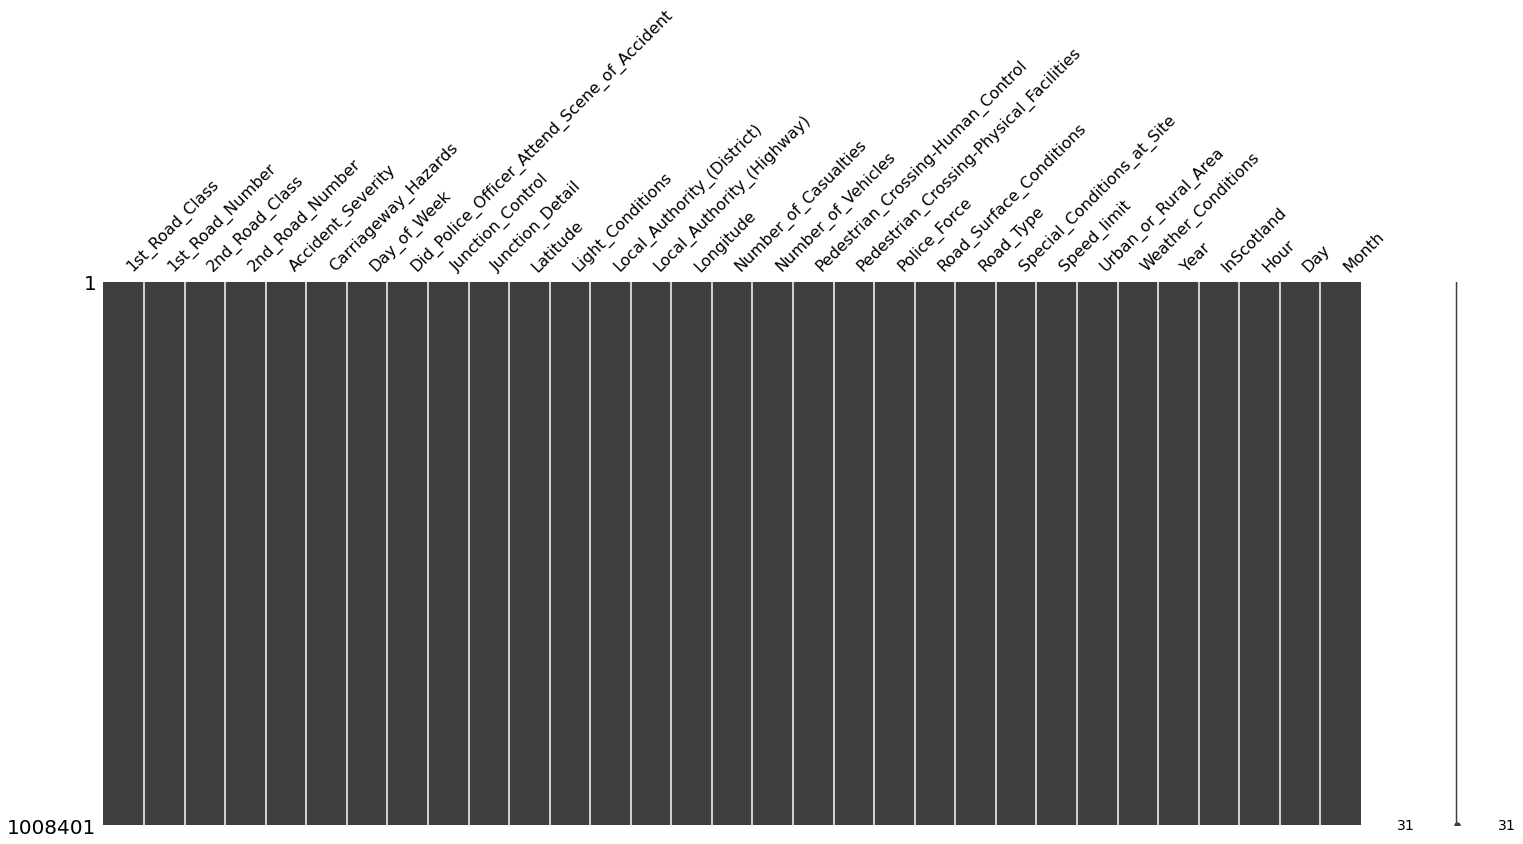

In [24]:
import missingno as msno

msno.matrix(df3)

In [25]:
#label encoder on cat_cols
label_encoder=LabelEncoder()
for cat_cols in cat_cols:
    df3[cat_cols]= label_encoder.fit_transform(df3[cat_cols])

df3.sample(10)

,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Hour,Day,Month
145267,4,0.0,4,0.0,0,1,4,1.0,3,9,51.206324,1,106,93,1.385723,1,2,0.0,0.0,23,0,3,5,30,2,1,2005,0,18,3,11
649742,5,1.0,5,1.0,0,1,5,1.0,3,8,51.727323,1,334,83,-0.390044,1,2,0.0,0.0,21,0,0,9,70,0,1,2008,0,21,22,4
116818,2,656.0,4,0.0,0,1,6,1.0,4,4,51.898413,4,238,83,-0.243526,1,1,0.0,0.0,21,0,3,5,60,0,1,2005,0,6,12,1
241555,3,37.0,4,0.0,1,1,5,1.0,2,4,54.664149,4,298,42,-1.520911,2,1,0.0,0.0,12,4,3,5,60,0,1,2006,0,9,31,1
120475,2,1369.0,4,0.0,0,1,2,1.0,3,9,51.797645,1,361,65,1.150479,1,1,0.0,0.0,14,0,3,5,30,2,1,2005,0,20,26,3
784817,4,0.0,2,4551.0,0,1,6,1.0,3,9,52.400600,4,47,209,-2.053615,1,2,0.0,0.0,47,0,3,5,30,0,1,2009,0,18,24,6
362673,2,939.0,2,940.0,1,1,1,1.0,3,9,56.306860,4,140,67,-2.943522,1,2,0.0,0.0,15,0,3,5,30,0,1,2006,1,8,24,7
774098,4,0.0,4,0.0,0,1,0,1.0,3,0,52.470210,4,24,11,-1.865563,1,2,0.0,0.0,48,0,3,5,30,2,1,2009,0,19,19,6
734142,4,0.0,2,271.0,1,1,1,1.0,3,9,51.356817,4,350,181,-0.151142,1,1,0.0,0.0,29,4,3,5,30,2,4,2009,0,7,16,11
642693,2,1108.0,4,0.0,0,1,2,1.0,2,4,52.569100,4,38,122,0.895427,1,2,0.0,0.0,30,0,3,5,60,0,1,2008,0,9,16,8


In [26]:
#create a copy of df3
df4=df3.copy()

In [27]:
#identify dependent and independent variables
X=df4.drop('Accident_Severity', axis=1)
y=df4.Accident_Severity

In [28]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [29]:
def Feature_Scaling(X_train, X_test):
    scaler = StandardScaler()
    X_train_after_Scaling=scaler.fit_transform(X_train)
    X_test_after_Scaling=scaler.fit_transform(X_test)
    return X_train_after_Scaling, X_test_after_Scaling

In [30]:
X_train_after_Scaling,X_test_after_Scaling=Feature_Scaling(X_train,X_test)

Text(0.5, 1.0, 'X_train_after_Scaling')

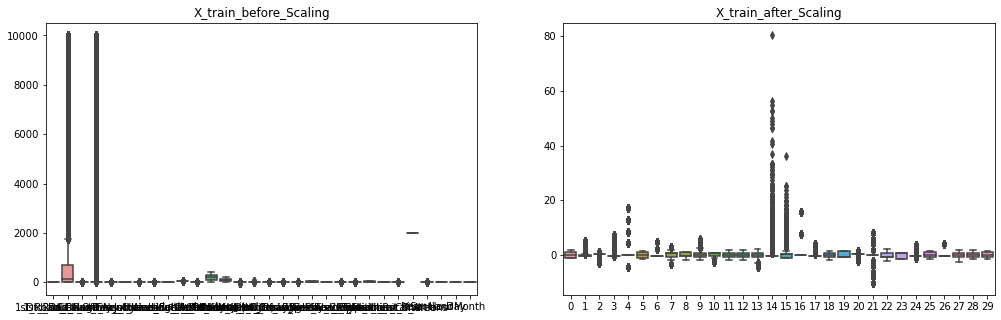

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(17,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('X_train_before_Scaling')
plt.subplot(1,2,2)
sns.boxplot(data=X_train_after_Scaling)
plt.title('X_train_after_Scaling')

In [32]:
X_train_after_Scaling=pd.DataFrame(X_train_after_Scaling)
X_train_after_Scaling

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-1.021242,-0.545208,0.414249,-0.293664,-0.070949,-1.445277,-0.47586,-1.908674,1.218977,-0.687332,0.567635,-0.317811,-0.395210,1.205388,0.765884,3.002627,-0.073062,2.456855,0.075171,-0.680644,-2.198892,-0.108205,0.728840,0.756669,-0.432755,-1.380951,-0.252848,-0.884870,-1.325745,1.273942
1,-1.021242,1.865442,0.414249,-0.293664,-0.070949,-0.477943,-0.47586,-0.670177,-0.537057,-0.444160,0.567635,-1.126531,0.555171,0.240388,-0.439536,-1.158893,-0.073062,-0.390286,1.231896,-0.680644,0.503672,-0.108205,0.728840,-1.321608,-0.432755,0.985562,-0.252848,1.036326,-0.526223,-0.768617
2,0.062493,2.869834,0.414249,-0.293664,-0.070949,1.456725,-0.47586,-0.670177,-0.537057,0.814456,-1.877375,0.977791,-0.089730,-0.876065,0.765884,-1.158893,-0.073062,-0.390286,-0.286306,1.521951,0.503672,-0.108205,-0.664040,0.756669,-0.432755,0.985562,-0.252848,1.420565,-1.325745,1.273942
3,1.146227,-0.551769,0.414249,-0.293664,-4.365355,0.489391,-0.47586,1.806818,-0.537057,-1.205989,-0.247368,-0.746928,-0.887372,-0.389234,3.176724,-1.158893,-0.073062,-0.390286,-1.298441,-0.680644,0.503672,-0.108205,1.425281,-1.321608,-0.432755,-0.197694,-0.252848,1.420565,0.273299,0.982148
4,1.146227,-0.551769,0.414249,-0.293664,-0.070949,0.005724,-0.47586,0.568321,1.218977,-1.151581,-1.877375,-0.260046,1.641321,0.842676,0.765884,-1.158893,-0.073062,-0.390286,1.087306,-0.680644,0.503672,-0.108205,-0.664040,-1.321608,-0.432755,1.577191,-0.252848,-2.613946,1.415473,-1.060412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806715,-0.479374,-0.551222,0.414249,-0.293664,-0.070949,-1.445277,-0.47586,1.806818,-0.537057,-0.437904,0.567635,0.259846,-0.361268,0.894940,-0.439536,0.228280,-0.073062,-0.390286,-0.503192,-0.680644,-2.198892,-0.108205,2.121721,-1.321608,-0.432755,1.577191,-0.252848,0.652087,-1.554179,-0.768617
806716,1.688095,-0.551222,0.414249,-0.293664,-0.070949,-1.445277,-0.47586,1.806818,-0.537057,-0.633906,0.567635,-0.301307,-0.361268,0.782099,0.765884,1.615454,-0.073062,-0.390286,-0.503192,-0.680644,1.404527,-0.108205,2.121721,-1.321608,-0.432755,-1.380951,-0.252848,0.267848,0.615951,0.982148
806717,-1.021242,0.010844,0.414249,-0.293664,-0.070949,-1.445277,-0.47586,0.568321,0.165357,0.698981,-1.877375,0.292854,0.385460,0.599219,0.765884,0.228280,-0.073062,-0.390286,-0.430896,1.521951,0.503672,-0.108205,0.032400,0.756669,2.301880,-0.197694,-0.252848,-1.653348,-0.412005,0.982148
806718,1.146227,-0.551769,0.414249,-0.293664,-0.070949,0.005724,-0.47586,0.568321,0.516564,-0.546840,-1.877375,1.274871,-0.666747,1.790610,-0.439536,0.228280,-0.073062,-0.390286,-1.009259,-0.680644,-0.397183,-0.108205,-0.664040,-1.321608,-0.432755,-0.789323,-0.252848,-1.845467,1.643908,0.106765


In [33]:
#counts('Junction_Control')

In [34]:
#def counts(col):
 #   return df2[col].value_counts()

In [35]:
#next Scaling, PCA
df3['Accident_Severity'].value_counts()

0    860259
1    134018
2     14124
Name: Accident_Severity, dtype: int64

In [36]:
corr_matrix=df3.corr()
corr_matrix['Accident_Severity'].sort_values(ascending=False)

Accident_Severity                              1.000000
Number_of_Casualties                           0.098224
Speed_limit                                    0.080676
2nd_Road_Class                                 0.049441
InScotland                                     0.031603
Latitude                                       0.029814
Road_Type                                      0.015817
Carriageway_Hazards                            0.003918
1st_Road_Number                                0.001457
Day                                            0.001387
Month                                          0.001097
Local_Authority_(District)                     0.001055
Hour                                          -0.000555
Year                                          -0.002706
Local_Authority_(Highway)                     -0.003021
Longitude                                     -0.003535
Pedestrian_Crossing-Physical_Facilities       -0.004308
Police_Force                                  -0